In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import _spin_params as spin_pars
from importlib import reload
from _steady_state import a_steady, purcell
from _helper_functions import create_sorting_indices, create_sorting_indices_small, clean_julia, format_julia_sol_2ndorder, solve_julia_problem, tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left
from _helper_functions import jl, Main, remake_julia_problem
from _create_pdf import create_spins, create_spins_inhomo_g
from _do_calculation import test_mbes_2ndorder2, test_mbes_2ndorder, test_mbes_2ndorder_julia, test_jac_2ndorder, setup_mbes_2ndorder, solve_mbes_2ndorder, solve_mbes_general, solve_mbes, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay, solve_obes
from _mbes import mbes, mbes_soc, mbes_soc_no_cavity, mbes_soc_det, obes_soc, mbes_2ndorder
import matplotlib
# matplotlib.use('NbAgg')
import numpy as np
from scipy.stats import logistic
from scipy.optimize import basinhopping
from scipy.special import erf
from scipy import interpolate
from IPython.display import clear_output, Javascript, Markdown, HTML
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib import cm
import scipy.io
import gc
#from qutip import Bloch
from matplotlib.animation import FuncAnimation
import datetime
import time
import random
import matplotlib
import _sys_helpers
from _jacobian import jacobian_mbes_2ndorder_real
# _sys_helpers.copy_connection_file()
%connect_info
# matplotlib.pyplot.switch_backend('nbagg')

{
  "shell_port": 41873,
  "iopub_port": 58895,
  "stdin_port": 45197,
  "control_port": 52475,
  "hb_port": 47385,
  "ip": "128.131.61.34",
  "key": "8444a22a-424790cbbb79a8ce1eb296a4",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-62fbafe5-2b88-4015-85f2-514f94f812f1.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


In [2]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr
kappa = np.pi*fr/quali  # HWHM
delta = spin_pars.delta  # detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac  # detuning drive to cavity wc-wp
gperp = spin_pars.gperp  # HWHM
gpar = spin_pars.gpar  # 0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = 301  # pin_pars.nbins  # 701#5000#20
g_number = spin_pars.g_number  # how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
nreal = spin_pars.nreal
spin_dist_width = spin_pars.spin_dist_width
print(kappa)
# %qtconsole

3.751201656087927


In [3]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse


def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002) * \
        (1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse


def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    tend = np.pi/wgrund

    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004) * \
        (1-logistic.cdf(t, loc=tend-0.02, scale=0.004))

    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq

In [4]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)


x_start = 5
x_stop = 20  # µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

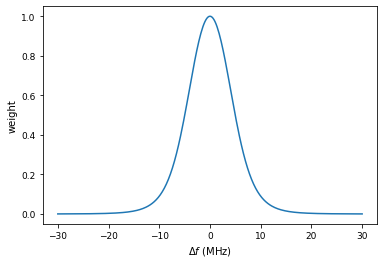

Cooperativity is: 9.232684


In [5]:
plt.close('all')
matplotlib.interactive(False)
spins, gs, pdf = create_spins_inhomo_g(
    gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True, spin_width=spin_dist_width)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight')
plt.show()
# %qtconsole
coop = gcoll**2/kappa*np.sum(pdf/(gperp+1j*2*np.pi*spins))
print("Cooperativity is: %f" % coop.real)
# %qtconsole

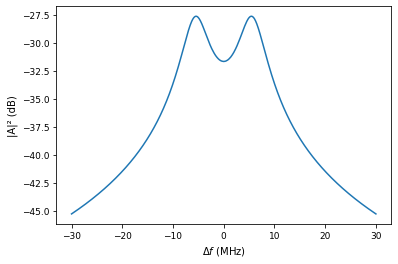

In [6]:
plt.close('all')
matplotlib.interactive(False)

initsteady = (0.001, 0.001)
fstart = 30
deltaarr = np.linspace(-fstart*2*np.pi, fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)')
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
plt.show()
# %qtconsole
#deltaarr[find(losasteady == max(losasteady))]/2/pi

# SOC pulses

In [7]:
pumptime = 50e-3  # 5*np.pi/gcoll
decaytime = 500e-3
dt = 0.0005
numsteps = int(pumptime/dt)
tlist = np.arange(0, pumptime+dt, dt)
tlistdecay = np.arange(0, decaytime+dt, dt)
init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1:len(spins)+1] = 0

## Calibrate power

In [8]:
pulsei = np.ones((len(tlist)))
pin = np.arange(-30,
                -20, 1)
aref = 4100

alos = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
szlos = np.zeros(np.shape(alos))
szall = np.zeros((len(pin), len(tlist)+len(tlistdecay), nbins))
small = np.zeros(np.shape(szall))
smlos = np.zeros(np.shape(alos))

for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    asolpump, asoldecay, infodict = solve_mbes(
        mbes, init, pdf, tlist, tlistdecay, dr, kappa, deltac, gs, gperp, spins, gpar)
    alos[ctr, :] = np.hstack((abs(asolpump[:, 0])**2, abs(asoldecay[:, 0])**2))
    szlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 2::2], axis=1)), np.real(
        np.sum(asoldecay[:, 2::2], axis=1))))
    szall[ctr, :, :] = np.vstack(
        (np.real(asolpump[:, 2::2]), np.real(asoldecay[:, 2::2])))
    small[ctr, :, :] = np.vstack(
        (np.real(asolpump[:, 1::2]), np.real(asoldecay[:, 1::2])))
    smlos[ctr, :] = np.hstack((np.real(np.sum(asolpump[:, 1::2], axis=1)), np.real(
        np.sum(asoldecay[:, 1::2], axis=1))))
# %qtconsole

-23


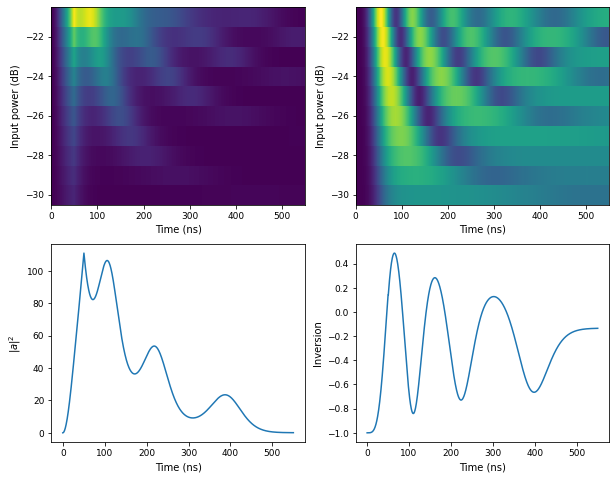

In [9]:
plt.close('all')
matplotlib.interactive(False)
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
#fig.set_size_inches([12, 8])
ax1.pcolor(tplot, pin, alos)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)')

ax2.pcolor(tplot, pin, szlos)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)')
maxAmpl = abs(asolpump).max()

idxinv = 7
print(pin[idxinv])
ax3.plot(tplot, alos[idxinv, :])
#ax3.set_ylim([0, 1])
ax3.set_xlabel('Time (ns)')
ax3.set_ylabel('$|a|^2$')
ax4.plot(tplot, szlos[idxinv, :])
ax4.set_xlabel('Time (ns)')
ax4.set_ylabel('Inversion')
plt.show()
# %qtconsole

### Compare to second order

In [10]:
init = np.ones(len(spins)*2+1)*(-1)
init[0] = 0
init[1:len(spins)+1] = 0
# 1st order
# asolpump, asoldecay, infodict = solve_mbes(
#    mbes, init, pdf, tlist, tlistdecay, dr, kappa, deltac, gs, gperp, spins, gpar)
#alos1storder = np.hstack((abs(asolpump[:, 0])**2, abs(asoldecay[:, 0])**2))
init2nd = np.zeros(5*(len(spins)*(len(spins)-1))//2+len(spins)*5+3)
init2nd[(nbins*4+3):(nbins*5+3)] = -1.
init2nd[(nbins*5+3)+2*nbins*(nbins-1):(nbins*5+3) +
        2*nbins*(nbins-1)+nbins*(nbins-1)//2] = 1.
initpump = np.asarray(init2nd, dtype=np.complex128)

In [11]:
# initrand = np.random.uniform(-1, 1, len(initpump)) + \
#    1j*np.random.uniform(-1, 1, len(initpump))
#nspins = nbins
#initrand[(nbins*4+3):(nbins*5+3)] = initrand[(nbins*4+3):(nbins*5+3)].real
# initrand[(nspins*5+3)+2*nspins*(nspins-1):(nspins*5+3)+2*nspins*(nspins-1)+nspins*(nspins-1) //
#         2] = initrand[(nspins*5+3)+2*nspins*(nspins-1):(nspins*5+3)+2*nspins*(nspins-1)+nspins*(nspins-1)//2].real


# test1 = test_mbes_2ndorder2(mbes_2ndorder, initrand, pdf, tlist, tlistdecay,
#                            gs, dr, kappa, gperp, gpar, spins, deltac)
# test2 = test_mbes_2ndorder(mbes_2ndorder, initrand, pdf, tlist, tlistdecay,
#                           gs, dr, kappa, gperp, gpar, spins, deltac)
#diff = test1-test2
# print(diff)

In [12]:
setup_mbes_2ndorder(mbes_2ndorder, initpump, pdf, tlist, tlistdecay,
                    gs, dr, kappa, gperp, gpar, spins, deltac)
clean_julia()

In [13]:
alos2nd = np.zeros((len(pin), len(tlist)+len(tlistdecay)))
gc.collect()
for ctr, p in enumerate(pin):
    dr = aref*10**(p/20.)
    remake_julia_problem(params=(dr,))
    sol = solve_julia_problem(tlist, tlistdecay)
    pumplos, decaylos = format_julia_sol_2ndorder(
        sol, tlist, tlistdecay, init2nd, pdf)
    alos2nd[ctr, :] = np.hstack(
        (abs(pumplos[:, 0])**2, abs(decaylos[:, 0])**2))
    print("Done with %i from %i" % (ctr+1, len(pin)), end="\r")
    clean_julia()
clean_julia()
Main.problem = None
clean_julia()

-23


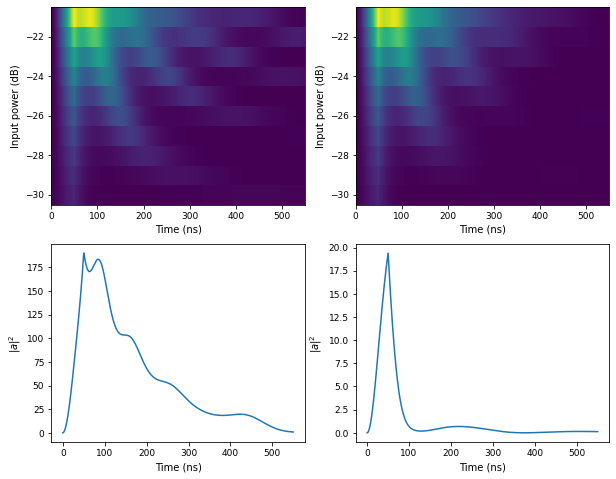

In [14]:
plt.close('all')
matplotlib.interactive(False)
tplot = np.linspace(0, 1000*(pumptime+decaytime), len(tlist)+len(tlistdecay))
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 8))
#fig.set_size_inches([12, 8])
ax1.pcolor(tplot, pin, alos)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Input power (dB)')

ax2.pcolor(tplot, pin, alos2nd)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Input power (dB)')
maxAmpl = abs(asolpump).max()

print(pin[idxinv])
ax3.plot(tplot, alos[-1, :])
#ax3.set_ylim([0, 1])
ax3.set_xlabel('Time (ns)')
ax3.set_ylabel('$|a|^2$')
ax4.plot(tplot, alos2nd[0, :])
#ax4.plot(tplot, alos[idxinv, :], '--')
ax4.set_xlabel('Time (ns)')
ax4.set_ylabel('$|a|^2$')
plt.show()
# %qtconsole;

In [15]:
%qtconsole
"""initrand = np.random.uniform(-1, 1, len(initpump)) + \
    1j*np.random.uniform(-1, 1, len(initpump))

deltasrand = np.random.uniform(-10, 10, len(gs))

spinsrand = np.random.uniform(-10, 10, len(gs)) + \
    1j*np.random.uniform(-10, 10, len(gs))*0

spinsrand, gsrand, pdfrand = create_spins_inhomo_g(
    gcoll, g_list, q, deltasrand, gammaq, nbins, holes=False, inhomo=True, hyperfine=True, spin_width=spin_dist_width)

testdata = test_mbes_2ndorder(mbes_2ndorder, initrand, pdfrand, tlist, tlistdecay,
                              gsrand, dr, kappa, gperp, gpar, spinsrand, deltac)
testjac, jitf, allargs = test_jac_2ndorder(jacobian_mbes_2ndorder_real, initrand, pdfrand, tlist, tlistdecay,
                                           gsrand, dr, kappa, gperp, gpar, spinsrand, deltac)
scipy.io.savemat("/home/andreas/Physics/julia/parameter.mat", {
    "gs": gsrand, "pdf": pdf, "gperp": gperp, "gpar":
    gpar, "deltac": deltac, "init": initrand, 'jac': testjac,
    "eta": dr, "kappa": kappa, "tpump": tlist, "tdecay": tlistdecay, "spins": spinsrand, "tplot": tplot, "firstord": alos[idxinv, :], "secondord": alos2nd[idxinv, :], 'testdata': testdata})""";